In [ ]:
api_key =   #replace it with openAI api key
load_trained_data = 1
run_openAI_experiments = 1-load_trained_data
# Provide the folder ID from the Google Drive link where item embeddings are loaded
folder_id = '18Ryk87NyHuGydGvhNYgBG3d0bpbBX8r_'

In [ ]:
!pip install openai==0.28.0
!pip install faiss-cpu
!pip install sentence-transformers
# Install PyDrive
!pip install -U -q PyDrive
import openai
openai.api_key = api_key

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.52.2
    Uninstalling openai-1.52.2:
      Successfully uninstalled openai-1.52.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 11.8 MB/s eta 0:00:00


## Utility Functions

In [ ]:
import numpy as np
import pandas as pd
def print_statistics(data):
    total_interactions = data.shape[0]
    unique_users = data['userId'].nunique()
    unique_items = data['itemId'].nunique()

    print("--------------------------")
    print("The Dataset Overview:")
    print(f" - Total Interactions: {total_interactions}")
    print(f" - |U|: {unique_users}")
    print(f" - |I|: {unique_items}")
    print(f" - |R|/|U|: {total_interactions / unique_users:.2f}")
    print(f" - |R|/|I|: {total_interactions / unique_items:.2f}")
    print(f" - |R|/(|U|*|I|): {total_interactions / (unique_users * unique_items):.10f}")
    print("--------------------------")
# print_statistics(train_df)
# print_statistics(test_df)


def sample_users(df_ratings, num_users):
    # Get a list of unique users
    unique_users = df_ratings['userId'].unique()

    # Sample a specified number of users
    sampled_users = pd.Series(unique_users).sample(n=num_users, random_state=42)

    # Get all ratings for the sampled users
    df_sampled_ratings = df_ratings[df_ratings['userId'].isin(sampled_users)]

    return df_sampled_ratings


def apply_interaction_limits(data, min_interactions, max_interactions, user_col, item_col):
    # Count the number of interactions by user
    interaction_counts = data[user_col].value_counts()

    # Filter out users outside the interaction limits
    users_to_keep = interaction_counts[(interaction_counts >= min_interactions) & (interaction_counts <= max_interactions)].index
    return data[data[user_col].isin(users_to_keep)]


def analyze_tags(df_item):
    # Count unique item IDs
    unique_item_ids = df_item['itemId'].nunique()

    # Count unique tags across all items (flattening the lists first)
    unique_tags = set(tag for sublist in df_item['tag'] for tag in sublist)
    unique_tags_count = len(unique_tags)

    # Count how many items have at least one tag
    items_with_tags = df_item[df_item['tag'].apply(lambda tags: len(tags) > 0)].shape[0]

    # Count how many items have no tags
    total_items = df_item.shape[0]
    items_without_tags = total_items - items_with_tags

    # Normalize to the entire number of items to get percentages
    items_with_tags_percentage = (items_with_tags / total_items) * 100
    items_without_tags_percentage = (items_without_tags / total_items) * 100

    # Print the results
    print(f"Total unique items (itemId): {unique_item_ids}")
    print(f"Total unique tags: {unique_tags_count}")
    print(f"Items with at least one tag: {items_with_tags} ({items_with_tags_percentage:.2f}%)")
    print(f"Items with no tags: {items_without_tags} ({items_without_tags_percentage:.2f}%)")


def check_column_for_nan(df, column_name):
    """
    Checks if a column in a DataFrame, identified by its name, contains NaN values.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.
    column_name (str): The name of the column to check for NaN values.

    Returns:
    int: 1 if NaN values are found, 0 if no NaN values are present.
    """
    # Ensure the column_name exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Return 1 if NaN values are found, otherwise return 0
    return int(df[column_name].isna().any())


# Introduce a NaN value in the 'tags' column
data = {
    'title': ['Movie A', 'Movie B', 'Movie C'],
    'genres': ['Action', 'Drama', 'Comedy'],
    'tags': ['Tag1', np.nan, 'Tag3']  # Introducing NaN in the 'tags' column
}

df = pd.DataFrame(data)
display(df)
# Check if the 'tags' column has NaN values
result = check_column_for_nan(df, 'tags')
print(f"'tags' column has NaN values: {result}")

# Check if the 'title' column has NaN values
result = check_column_for_nan(df, 'title')
print(f"'title' column has NaN values: {result}")


,title,genres,tags
0,Movie A,Action,Tag1
1,Movie B,Drama,NaN
2,Movie C,Comedy,Tag3


'tags' column has NaN values: 1
'title' column has NaN values: 0


In [ ]:
import requests
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def download_csv(url, csv_file_name):
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        with open(csv_file_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"{csv_file_name} downloaded successfully.")
        return True
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
        return False


# Function to visualize the exact timestamps of movies watched for a random user
def visualize_user_exact_interaction(train_df, test_df):
    """
    Visualize exact movie watch interactions for a random user from the training and test datasets.

    Parameters:
        train_df (pd.DataFrame): Training set.
        test_df (pd.DataFrame): Test set.
    """
    # Select a random user from the combined dataset
    combined_df = pd.concat([train_df, test_df])
    random_user = np.random.choice(combined_df['userId'].unique())

    # Filter train and test data for the selected user
    user_train_data = train_df[train_df['userId'] == random_user]
    user_test_data = test_df[test_df['userId'] == random_user]

    # Convert timestamp to datetime
    user_train_data['datetime'] = pd.to_datetime(user_train_data['timestamp'], unit='s')
    user_test_data['datetime'] = pd.to_datetime(user_test_data['timestamp'], unit='s')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.scatter(user_train_data['datetime'], [1]*len(user_train_data), color='skyblue', alpha=0.75, label='Train')
    plt.scatter(user_test_data['datetime'], [1]*len(user_test_data), color='orange', alpha=0.75, label='Test')
    plt.title(f'Movie Watches for User {random_user}')
    plt.xlabel('Datetime')
    plt.yticks([])  # Hide y-axis labels
    plt.legend()
    plt.grid(axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# Function to check the percentage of overlapping items between train and test sets
def check_overlap(train_df: pd.DataFrame, test_df: pd.DataFrame) -> float:
    """
    Check the percentage of overlapping items between training and test datasets.

    Parameters:
        train_df (pd.DataFrame): Training set.
        test_df (pd.DataFrame): Test set.

    Returns:
        float: Percentage of items shared between train and test sets.
    """
    train_items = set(train_df['itemId'].unique())
    test_items = set(test_df['itemId'].unique())
    overlapping_items = train_items.intersection(test_items)
    overlap_percentage = (len(overlapping_items) / len(train_items.union(test_items))) * 100
    print(f"Percentage of items shared between train and test sets: {overlap_percentage:.2f}%")
    return overlap_percentage

##Load and Read Pretrained Item Embeddings

In [ ]:
# Import necessary libraries
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Function to list and download files from a Google Drive folder
def download_files_from_folder(folder_id):
    # List all files in the folder
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

    print(f'Found {len(file_list)} files in the folder.')

    # Create a local directory to save downloaded files
    if not os.path.exists('drive_folder'):
        os.makedirs('drive_folder')

    # Download each file
    for file in file_list:
        print(f'Downloading {file["title"]}...')
        file.GetContentFile(f'drive_folder/{file["title"]}')
        print(f'Downloaded: {file["title"]}')


# Call the function to download files
download_files_from_folder(folder_id)

# List the downloaded files
print("Downloaded files:")
!ls drive_folder


Found 27 files in the folder.
Downloaded: df_items_adversarialAttack_with_embeddings_tag_local_7.csv
Downloaded: df_items_adversarialAttack_with_embeddings_tag_local_5.csv
Downloaded: df_items_adversarialAttack_with_embeddings_tag_7.csv
Downloaded: df_items_adversarialAttack_with_embeddings_tag_5.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_local_5.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_global_5.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tags_7.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tags_5.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_global_3.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_local_3.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_local_1.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_global_1.csv
Downloaded: df_items_adversarialAttack_with_embeddings_ta

In [ ]:
itemEmbeddding_model = 'Embedding_TitleGenreTags_text-embedding-ada-002' #'Embedding_TitleGenreGenTags_text-embedding-ada-002'
#itemEmbeddding_model = 'Embedding_TitleGenreGenTags_text-embedding-ada-002'

if itemEmbeddding_model == 'Embedding_TitleGenreTags_text-embedding-ada-002':
  # this contain embedding for movie in the form of [title, genre, tags]
  file = "enriched_dataset_ml-latest-small_filtering_min_20_max_100_gpt-3.5-turbo_Embedding_TitleGenreTags_text-embedding-ada-002.csv"
  org_colName = "tag"
  trg_colName = "combined_text_Tags"
  trg_colEmb = "embedding_combined_Tagstext-embedding-ada-002"
elif itemEmbeddding_model == 'Embedding_TitleGenreGenTags_text-embedding-ada-002': # Choose for Generated Tags
  # this contain embedding for movie in the form of [title, genre, gen_tags]
  file = "enriched_dataset_ml-latest-small_filtering_min_20_max_100_gpt-3.5-turbo_Embedding_TitleGenreGenTags_text-embedding-ada-002.csv"
  org_colName = "generated_tags"
  trg_colName = "combined_text_genTags"
  trg_colEmb = "embedding_combined_generatedTagstext-embedding-ada-002"



#file = f"enriched_dataset_ml-latest-small_filtering_min_20_max_100_gpt-3.5-turbo_{item_emb}.csv"
fileName = "drive_folder/" + file
df_items = pd.read_csv(fileName)
display(df_items)


# Assuming your dataframe is named df, and you want to access the last two columns for a specific row index, e.g., index 0:
row_index = 0
#df_items.loc[row_index, [trg_colName, trg_colEmb]]
# Convert the specific row and columns to a dictionary for better readability
output_dict = df_items.loc[row_index, [trg_colName, trg_colEmb]].to_dict()
print(output_dict)



file1 = f"train_data_enriched_dataset_ml-latest-small_filtering_min_20_max_100.csv"
file2 = f"test_data_enriched_dataset_ml-latest-small_filtering_min_20_max_100.csv"
fileName = "drive_folder/" + file1
train_df = pd.read_csv(fileName)

fileName = "drive_folder/" + file2
test_df = pd.read_csv(fileName)

display(train_df)
display(test_df)


# Concatenate train_df and test_df
df_ratings = pd.concat([train_df, test_df], ignore_index=True)

# Display the shape of the new combined DataFrame
print("Combined Ratings DataFrame Shape:", df_ratings.shape)

display(df_ratings)


,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags,combined_text_Tags,embedding_combined_Tagstext-embedding-ada-002
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"['hit men', 'reunion']","""Grosse Pointe Blank"" is a captivating blend o...","['forefront', 'professional', 'rollercoaster',...",forefront professional rollercoaster pointe jo...,"['debi', 'grosse', 'blank', 'pointe', 'sweethe...","Title: Grosse Pointe Blank (1997), Genre: Come...","[0.0023945507127791643, -0.03080049529671669, ..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,[],"""The Mask"" (1994) is a wildly entertaining act...","['genre', 'bank', 'lesson', 'embrace', 'misuse...",genre bank lesson embrace misuse slapstick tin...,"['ipkiss', 'dorian', 'misuse', 'trickster', 't...","Title: Mask, The (1994), Genre: Action|Comedy|...","[-0.011142779141664505, -0.037081919610500336,..."
2,84152,Limitless (2011),Sci-Fi|Thriller,[],"""Limitless"" (2011) is a riveting Sci-Fi thrill...","['powerful', 'smart', 'morra', 'tension', 'sky...",powerful smart morra tension skyrocket care po...,"['nootropic', 'ascent', 'morra', 'loon', 'abbi...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","[-0.0024675088934600353, -0.030259277671575546..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,[],"""Gone in 60 Seconds (2000)"" is a high-octane a...","['angelina', 'auto', 'dominic', 'brother', 'st...",angelina auto dominic brother steal ensemble v...,"['vinnie', 'fifty', 'vehicle', 'auto', 'zoom',...","Title: Gone in 60 Seconds (2000), Genre: Actio...","[-0.005836763419210911, -0.014308635145425797,..."
4,3238,Eye of the Beholder (1999),Thriller,[],"""Eye of the Beholder"" (1999) is a riveting thr...","['ewan', 'tension', 'expert', 'ashley', 'obses...",ewan tension expert ashley obsession deepest s...,"['beholder', 'eris', 'joanna', 'ashley', 'judd...","Title: Eye of the Beholder (1999), Genre: Thri...","[-0.01010273490101099, -0.03785362094640732, -..."
...,...,...,...,...,...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,['books'],"""84 Charing Cross Road"" is a heartwarming and ...","['frank', 'unlikely', 'meaningful', 'sassy', '...",frank unlikely meaningful sassy correspondence...,"['doel', 'bookseller', 'antiquarian', 'hanff',...","Title: 84 Charing Cross Road (1987), Genre: Dr...","[-0.004216748755425215, -0.01860734447836876, ..."
3075,53894,Sicko (2007),Documentary|Drama,[],"""Sicko"" (2007) is a thought-provoking document...","['powerful', 'profound', 'change', 'portrays',...",powerful profound change portrays care greed j...,"['sicko', 'famed', 'indictment', 'fundamental'...","Title: Sicko (2007), Genre: Documentary|Drama,...","[-0.005371647886931896, 0.0023576472885906696,..."
3076,1342,Candyman (1992),Horror|Thriller,[],"""Candyman"" (1992) is a chilling horror-thrille...","['genre', 'visceral', 'legend', 'mirror', 'spi...",genre visceral legend mirror spirit dark night...,"['perpetuate', 'candyman', 'whisper', 'housing...","Title: Candyman (1992), Genre: Horror|Thriller...","[0.0030703421216458082, -0.03260286897420883, ..."
3077,2917,Body Heat (1981),Crime|Thriller,[],"""Body Heat"" is a sultry and gripping crime thr...","['genre', 'town', 'walker', 'heat', 'drive', '...",genre town walker heat drive richard intricate...,"['racine', 'scorch', 'matty', 'crenna', 'kasda...","Title: Body Heat (1981), Genre: Crime|Thriller...","[-0.01281888596713543, -0.016018638387322426, ..."


{'combined_text_Tags': "Title: Grosse Pointe Blank (1997), Genre: Comedy|Crime|Romance, Tags: ['hit men', 'reunion']", 'embedding_combined_Tagstext-embedding-ada-002': '[0.0023945507127791643, -0.03080049529671669, -0.00749219348654151, -0.009511128067970276, -0.030344389379024506, 0.031471237540245056, 0.020511304959654808, -0.01168433390557766, -0.02835899218916893, -0.05164717137813568, 0.028815096244215965, 0.013019111007452011, 0.021490588784217834, -0.0019904281944036484, 0.006771145388484001, -0.013582535088062286, 0.024441855028271675, 0.005459843669086695, 0.02389184758067131, -0.01597708649933338, -0.00642571272328496, 0.008961119689047337, 0.005640944000333548, -0.0014747950481250882, 0.02287231758236885, -0.008598918095231056, 0.023516230285167694, -0.017908824607729912, -3.178166662110016e-05, -0.002002166351303458, -0.010805660858750343, -0.022925978526473045, -0.009262953884899616, -0.020283252000808716, -0.016017330810427666, -0.007445241324603558, -0.022308895364403725

,userId,itemId,rating,timestamp
0,1,1210,5.0,2000-07-30 18:08:19
1,1,2018,5.0,2000-07-30 18:08:43
2,1,2628,4.0,2000-07-30 18:08:43
3,1,2826,4.0,2000-07-30 18:08:43
4,1,3578,5.0,2000-07-30 18:11:08
...,...,...,...,...
65138,610,5959,3.5,2017-05-03 21:39:38
65139,610,60766,4.5,2017-05-03 21:39:43
65140,610,112171,3.5,2017-05-03 21:39:49
65141,610,55721,3.5,2017-05-03 21:40:11


,userId,itemId,rating,timestamp
0,1,1219,2.0,2000-07-30 18:56:33
1,1,1348,4.0,2000-07-30 18:56:33
2,1,2644,4.0,2000-07-30 18:56:33
3,1,1258,3.0,2000-07-30 18:56:54
4,1,1278,5.0,2000-07-30 18:56:54
...,...,...,...,...
16590,610,3727,4.0,2017-05-28 08:14:25
16591,610,70,4.0,2017-05-28 08:14:42
16592,610,328,3.5,2017-05-28 08:14:59
16593,610,2459,3.5,2017-05-28 08:16:45


Combined Ratings DataFrame Shape: (81738, 4)


,userId,itemId,rating,timestamp
0,1,1210,5.0,2000-07-30 18:08:19
1,1,2018,5.0,2000-07-30 18:08:43
2,1,2628,4.0,2000-07-30 18:08:43
3,1,2826,4.0,2000-07-30 18:08:43
4,1,3578,5.0,2000-07-30 18:11:08
...,...,...,...,...
81733,610,3727,4.0,2017-05-28 08:14:25
81734,610,70,4.0,2017-05-28 08:14:42
81735,610,328,3.5,2017-05-28 08:14:59
81736,610,2459,3.5,2017-05-28 08:16:45


## Filter rating_df with smaller item_df to create smaller rating_df

In [ ]:
import pandas as pd

# Assuming df_rating and df_items_merged_sampled are your DataFrames
common_item_ids = pd.merge(df_ratings, df_items, on='itemId')['itemId']

# Now filter both DataFrames to keep only those rows with common item IDs
df_rating_filtered = df_ratings[df_ratings['itemId'].isin(common_item_ids)]
df_items_filtered = df_items[df_items['itemId'].isin(common_item_ids)]
df_items = df_items_filtered.copy()

# Display the filtered DataFrames
#print(df_rating_filtered)
display(df_items)

# Ensure timestamps are in datetime format in df_rating
df_ratings = df_rating_filtered.copy()  # Avoid SettingWithCopyWarning
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'])
display(df_ratings)

,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags,combined_text_Tags,embedding_combined_Tagstext-embedding-ada-002
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"['hit men', 'reunion']","""Grosse Pointe Blank"" is a captivating blend o...","['forefront', 'professional', 'rollercoaster',...",forefront professional rollercoaster pointe jo...,"['debi', 'grosse', 'blank', 'pointe', 'sweethe...","Title: Grosse Pointe Blank (1997), Genre: Come...","[0.0023945507127791643, -0.03080049529671669, ..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,[],"""The Mask"" (1994) is a wildly entertaining act...","['genre', 'bank', 'lesson', 'embrace', 'misuse...",genre bank lesson embrace misuse slapstick tin...,"['ipkiss', 'dorian', 'misuse', 'trickster', 't...","Title: Mask, The (1994), Genre: Action|Comedy|...","[-0.011142779141664505, -0.037081919610500336,..."
2,84152,Limitless (2011),Sci-Fi|Thriller,[],"""Limitless"" (2011) is a riveting Sci-Fi thrill...","['powerful', 'smart', 'morra', 'tension', 'sky...",powerful smart morra tension skyrocket care po...,"['nootropic', 'ascent', 'morra', 'loon', 'abbi...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","[-0.0024675088934600353, -0.030259277671575546..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,[],"""Gone in 60 Seconds (2000)"" is a high-octane a...","['angelina', 'auto', 'dominic', 'brother', 'st...",angelina auto dominic brother steal ensemble v...,"['vinnie', 'fifty', 'vehicle', 'auto', 'zoom',...","Title: Gone in 60 Seconds (2000), Genre: Actio...","[-0.005836763419210911, -0.014308635145425797,..."
4,3238,Eye of the Beholder (1999),Thriller,[],"""Eye of the Beholder"" (1999) is a riveting thr...","['ewan', 'tension', 'expert', 'ashley', 'obses...",ewan tension expert ashley obsession deepest s...,"['beholder', 'eris', 'joanna', 'ashley', 'judd...","Title: Eye of the Beholder (1999), Genre: Thri...","[-0.01010273490101099, -0.03785362094640732, -..."
...,...,...,...,...,...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,['books'],"""84 Charing Cross Road"" is a heartwarming and ...","['frank', 'unlikely', 'meaningful', 'sassy', '...",frank unlikely meaningful sassy correspondence...,"['doel', 'bookseller', 'antiquarian', 'hanff',...","Title: 84 Charing Cross Road (1987), Genre: Dr...","[-0.004216748755425215, -0.01860734447836876, ..."
3075,53894,Sicko (2007),Documentary|Drama,[],"""Sicko"" (2007) is a thought-provoking document...","['powerful', 'profound', 'change', 'portrays',...",powerful profound change portrays care greed j...,"['sicko', 'famed', 'indictment', 'fundamental'...","Title: Sicko (2007), Genre: Documentary|Drama,...","[-0.005371647886931896, 0.0023576472885906696,..."
3076,1342,Candyman (1992),Horror|Thriller,[],"""Candyman"" (1992) is a chilling horror-thrille...","['genre', 'visceral', 'legend', 'mirror', 'spi...",genre visceral legend mirror spirit dark night...,"['perpetuate', 'candyman', 'whisper', 'housing...","Title: Candyman (1992), Genre: Horror|Thriller...","[0.0030703421216458082, -0.03260286897420883, ..."
3077,2917,Body Heat (1981),Crime|Thriller,[],"""Body Heat"" is a sultry and gripping crime thr...","['genre', 'town', 'walker', 'heat', 'drive', '...",genre town walker heat drive richard intricate...,"['racine', 'scorch', 'matty', 'crenna', 'kasda...","Title: Body Heat (1981), Genre: Crime|Thriller...","[-0.01281888596713543, -0.016018638387322426, ..."


,userId,itemId,rating,timestamp
0,1,1210,5.0,2000-07-30 18:08:19
1,1,2018,5.0,2000-07-30 18:08:43
2,1,2628,4.0,2000-07-30 18:08:43
3,1,2826,4.0,2000-07-30 18:08:43
4,1,3578,5.0,2000-07-30 18:11:08
...,...,...,...,...
81733,610,3727,4.0,2017-05-28 08:14:25
81734,610,70,4.0,2017-05-28 08:14:42
81735,610,328,3.5,2017-05-28 08:14:59
81736,610,2459,3.5,2017-05-28 08:16:45


## Define Short-head (popular), Mid-tail, and Long-tail Items

In [ ]:
import pandas as pd

# Compute the number of interactions per itemId directly from rating_df
item_interactions = df_ratings.groupby('itemId').size().reset_index(name='num_interactions')

# Merge the item_interactions DataFrame with item_df to add counts
df_items = df_items.merge(item_interactions, on='itemId', how='left')

# Fill NaN values with 0 for items with no interactions
df_items['num_interactions'] = df_items['num_interactions'].fillna(0)

# Calculate quantiles for defining popularity levels
level_2_threshold = df_items['num_interactions'].quantile(0.80)  # Top 20%
level_0_threshold = df_items['num_interactions'].quantile(0.20)  # Bottom 20%

# Assign labels based on count (0, 1, 2)
def assign_popularity_level(count):
    if count >= level_2_threshold:
        return 2  # Popular
    elif count >= level_0_threshold:
        return 1  # Mid-tail
    else:
        return 0  # Long-tail

df_items['popularity_level'] = df_items['num_interactions'].apply(assign_popularity_level)

# Displaying the resulting DataFrame with itemId and popularity_level
display(df_items.head(20))


,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags,combined_text_Tags,embedding_combined_Tagstext-embedding-ada-002,num_interactions,popularity_level
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"['hit men', 'reunion']","""Grosse Pointe Blank"" is a captivating blend o...","['forefront', 'professional', 'rollercoaster',...",forefront professional rollercoaster pointe jo...,"['debi', 'grosse', 'blank', 'pointe', 'sweethe...","Title: Grosse Pointe Blank (1997), Genre: Come...","[0.0023945507127791643, -0.03080049529671669, ...",59,2
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,[],"""The Mask"" (1994) is a wildly entertaining act...","['genre', 'bank', 'lesson', 'embrace', 'misuse...",genre bank lesson embrace misuse slapstick tin...,"['ipkiss', 'dorian', 'misuse', 'trickster', 't...","Title: Mask, The (1994), Genre: Action|Comedy|...","[-0.011142779141664505, -0.037081919610500336,...",157,2
2,84152,Limitless (2011),Sci-Fi|Thriller,[],"""Limitless"" (2011) is a riveting Sci-Fi thrill...","['powerful', 'smart', 'morra', 'tension', 'sky...",powerful smart morra tension skyrocket care po...,"['nootropic', 'ascent', 'morra', 'loon', 'abbi...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","[-0.0024675088934600353, -0.030259277671575546...",30,1
3,3717,Gone in 60 Seconds (2000),Action|Crime,[],"""Gone in 60 Seconds (2000)"" is a high-octane a...","['angelina', 'auto', 'dominic', 'brother', 'st...",angelina auto dominic brother steal ensemble v...,"['vinnie', 'fifty', 'vehicle', 'auto', 'zoom',...","Title: Gone in 60 Seconds (2000), Genre: Actio...","[-0.005836763419210911, -0.014308635145425797,...",61,2
4,3238,Eye of the Beholder (1999),Thriller,[],"""Eye of the Beholder"" (1999) is a riveting thr...","['ewan', 'tension', 'expert', 'ashley', 'obses...",ewan tension expert ashley obsession deepest s...,"['beholder', 'eris', 'joanna', 'ashley', 'judd...","Title: Eye of the Beholder (1999), Genre: Thri...","[-0.01010273490101099, -0.03785362094640732, -...",6,1
5,5419,Scooby-Doo (2002),Adventure|Children|Comedy|Fantasy|Mystery,[],"""Scooby-Doo"" (2002) is a delightful blend of a...","['invitation', 'relief', 'case', 'bizarre', 's...",invitation relief case bizarre steal excite ve...,"['shaggy', 'snack', 'scooby', 'thinker', 'happ...","Title: Scooby-Doo (2002), Genre: Adventure|Chi...","[0.006084173917770386, -0.03212596848607063, -...",17,1
6,7090,Hero (Ying xiong) (2002),Action|Adventure|Drama,['martial arts'],"""Hero (Ying xiong)"" is a visually stunning mar...","['different', 'warrior', 'dun', 'protagonist',...",different warrior dun protagonist tapestry int...,"['qin', 'dun', 'yimou', 'xiong', 'cheung', 'ta...","Title: Hero (Ying xiong) (2002), Genre: Action...","[-0.014134391210973263, -0.02726484276354313, ...",38,1
7,5313,The Scorpion King (2002),Action|Adventure|Fantasy|Thriller,[],"""The Scorpion King"" (2002) is a thrilling blen...","['warrior', 'unlikely', 'death', 'mercenary', ...",warrior unlikely death mercenary good mythical...,"['foreseen', 'mathayus', 'memnon', 'arpid', 'b...","Title: The Scorpion King (2002), Genre: Action...","[-0.007461847271770239, -0.028713291510939598,...",22,1
8,87413,Bernie (1996),Comedy|Drama,[],"""Bernie"" is a 1996 Comedy-Drama film that unra...","['genre', 'town', 'bernie', 'bank', 'heartstri...",genre town bernie bank heartstrings blanche tr...,"['noël', 'cécile', 'uchan', 'loser', 'dupontel...","Title: Bernie (1996), Genre: Comedy|Drama, Tag...","[-0.010809864848852158, -0.03699549287557602, ...",2,0
9,2640,Superman (1978),Action|Adventure|Sci-Fi,['superhero'],"""Superman"" (1978) is a classic film that has w...","['genre', 'luthor', 'elevate', 'withstood', 'i...",genre luthor elevate withstood introduction ma...,"['withstood', 'emergence', 'luthor', 'lex', 'm...","Title: Superman (1978), Genre: Action|Adventur...","[-0.002156567294150591, -0.023919180035591125,...",61,2


In [ ]:
# Specify the columns to extract
columns_to_extract = ['itemId', 'title', 'genres', 'num_interactions', 'popularity_level']

# Extract the specified columns
df_subset = df_items[columns_to_extract]

# Save the subset to a CSV file
df_subset.to_csv('df_items_with_popularity.csv', index=False)


In [ ]:
df_subset

,itemId,title,genres,num_interactions,popularity_level
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,59,2
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,157,2
2,84152,Limitless (2011),Sci-Fi|Thriller,30,1
3,3717,Gone in 60 Seconds (2000),Action|Crime,61,2
4,3238,Eye of the Beholder (1999),Thriller,6,1
...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,3,0
3075,53894,Sicko (2007),Documentary|Drama,14,1
3076,1342,Candyman (1992),Horror|Thriller,11,1
3077,2917,Body Heat (1981),Crime|Thriller,10,1


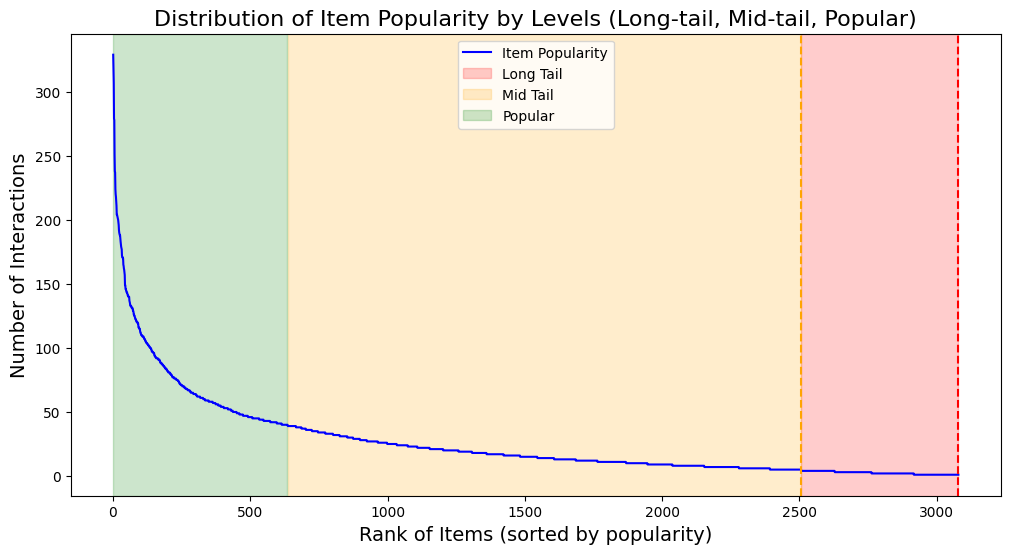

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort items by number of interactions in descending order
df_items_sorted = df_items.sort_values('num_interactions', ascending=False).reset_index()

# Create a rank column (ranked by popularity)
df_items_sorted['rank'] = np.arange(1, len(df_items_sorted) + 1)

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot the number of interactions versus the rank
plt.plot(df_items_sorted['rank'], df_items_sorted['num_interactions'], color='blue', label='Item Popularity')

# Determine the index values for the different levels of popularity
popular_items = df_items_sorted[df_items_sorted['popularity_level'] == 2]
mid_tail_items = df_items_sorted[df_items_sorted['popularity_level'] == 1]
long_tail_items = df_items_sorted[df_items_sorted['popularity_level'] == 0]

# Fill the areas for each popularity level
plt.axvspan(long_tail_items.index[0], long_tail_items.index[-1], color='red', alpha=0.2, label='Long Tail')
plt.axvspan(mid_tail_items.index[0], mid_tail_items.index[-1], color='orange', alpha=0.2, label='Mid Tail')
plt.axvspan(popular_items.index[0], popular_items.index[-1], color='green', alpha=0.2, label='Popular')

# Highlight the thresholds with vertical dashed lines
plt.axvline(x=long_tail_items.index[-1], color='red', linestyle='--')
plt.axvline(x=mid_tail_items.index[-1], color='orange', linestyle='--')

# Adding labels and title
plt.xlabel('Rank of Items (sorted by popularity)', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.title('Distribution of Item Popularity by Levels (Long-tail, Mid-tail, Popular)', fontsize=16)

# Correcting text annotations' positions for better alignment
#plt.text(long_tail_items.index[-1] / 3, max(df_items_sorted['num_interactions']) * 0.75, 'Long Tail', fontsize=12, color='red', ha='center', bbox=dict(facecolor='white', alpha=0.6))
#plt.text((long_tail_items.index[-1] + mid_tail_items.index[-1]) / 2, max(df_items_sorted['num_interactions']) * 0.25, 'Mid Tail', fontsize=12, color='orange', ha='center', bbox=dict(facecolor='white', alpha=0.6))
#plt.text((mid_tail_items.index[-1] + popular_items.index[-1]) / 2, max(df_items_sorted['num_interactions']) * 0.75, 'Popular', fontsize=12, color='green', ha='center', bbox=dict(facecolor='white', alpha=0.6))

# Display the legend
plt.legend()

# Display the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


show_emb_plots = 0

if show_emb_plots == 1:
  embeddings = df_items[trg_colEmb].apply(eval).tolist()

  # Convert the list of lists to a NumPy array
  embeddings = np.array(embeddings)

  # Perform t-SNE for dimensionality reduction to 2D
  tsne = TSNE(n_components=2, random_state=42)
  embedding_2d = tsne.fit_transform(embeddings)

  # Alternatively, you can use PCA for dimensionality reduction (faster but less expressive in high-dimensional spaces)
  # pca = PCA(n_components=2)
  # embedding_2d = pca.fit_transform(embeddings)

  # Create a scatter plot
  plt.figure(figsize=(10, 7))

  # Get unique popularity levels and assign a color to each
  unique_popularity_levels = df_items['popularity_level'].unique()
  colors = plt.cm.get_cmap('tab10', len(unique_popularity_levels))  # Use a colormap with enough distinct colors

  # Plot each item, colored by its popularity level
  for idx, row in df_items.iterrows():
      plt.scatter(embedding_2d[idx, 0], embedding_2d[idx, 1],
                  color=colors(row['popularity_level']),  # Automatically map popularity_level to a color
                  label=f"Popularity Level {row['popularity_level']}" if idx == 0 else "",  # To avoid duplicate labels
                  alpha=0.7)

  # Create a legend for popularity levels (ensure one legend entry per unique popularity level)
  handles, labels = plt.gca().get_legend_handles_labels()
  by_label = dict(zip(labels, handles))
  plt.legend(by_label.values(), by_label.keys())

  # Add labels and title
  plt.title('Item Embeddings Visualization using t-SNE')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')

  # Show the plot
  plt.show()


In [ ]:
long_tail_sample = df_items[df_items['popularity_level'] == 0].sample(5)  #
display(long_tail_sample)

,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags,combined_text_Tags,embedding_combined_Tagstext-embedding-ada-002,num_interactions,popularity_level
2507,7208,Dr. Jekyll and Mr. Hyde (1941),Drama|Horror,[],'Dr. Jekyll and Mr. Hyde' (1941) is a gripping...,"['tracy', 'hyde', 'tension', 'spencer', 'unabl...",tracy hyde tension spencer unable duality good...,"['emery', 'jekyll', 'barmaid', 'ivy', 'beatrix...","Title: Dr. Jekyll and Mr. Hyde (1941), Genre: ...","[-0.009307553991675377, -0.022340726107358932,...",2,0
1454,75446,Little Ashes (2008),Drama,[],"""Little Ashes"" (2008) is a captivating and emo...","['process', 'tension', 'spain', 'political', '...",process tension spain political luis passionat...,"['mcnulty', 'dalí', 'beltrán', 'lorca', 'buñue...","Title: Little Ashes (2008), Genre: Drama, Tags...","[-0.014697662554681301, -0.017039233818650246,...",1,0
1366,5387,Enough (2002),Drama|Thriller,[],"""Enough"" (2002) is a gripping drama-thriller t...","['survivor', 'powerful', 'abuse', 'tension', '...",survivor powerful abuse tension embrace justic...,"['tessa', 'gracie', 'ginny', 'slim', 'lopez', ...","Title: Enough (2002), Genre: Drama|Thriller, T...","[-0.002242444083094597, -0.03045269288122654, ...",3,0
2953,299,Priest (1994),Drama,[],"""Priest"" (1994) delves into the complex and pr...","['profound', 'judgment', 'church', 'roache', '...",profound judgment church roache deepest sin jo...,"['condemnation', 'pilkington', 'antonia', 'sta...","Title: Priest (1994), Genre: Drama, Tags: []","[0.006364751141518354, -0.03916565328836441, -...",4,0
1049,5410,Silent Running (1972),Drama|Sci-Fi,[],"""Silent Running"" (1972) is a thought-provoking...","['directive', 'powerful', 'greenhouse', 'contr...",directive powerful greenhouse contrast remain ...,"['huey', 'trumbull', 'greenhouse', 'lowell', '...","Title: Silent Running (1972), Genre: Drama|Sci...","[-0.004310159012675285, -0.019566860049962997,...",4,0


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random

"""
This script calculates item similarity for a recommendation dataset, assigning the most similar items
from different popularity classes (popular, mid-tail, long-tail) and validating the results.

Steps:
1. Compute cosine similarity of item embeddings and assign the top similar items, excluding the item itself.
2. Organize items by popularity levels in a dictionary for quick access.
3. For each item, store its most similar items across other popularity classes.
4. Select a random item from a specific class and validate its similar items belong to the expected class.
5. Display the updated DataFrame with similarity information.

Helper functions manage similarity retrieval and validation efficiently.
"""

# Precomputed embeddings and dataframe
embeddings = df_items[trg_colEmb].apply(eval).tolist()
similarity_matrix = cosine_similarity(embeddings)

# Ensure columns are initialized with empty lists
df_items['most_similar_items'] = [[] for _ in range(len(df_items))]
df_items['similarity_values'] = [[] for _ in range(len(df_items))]
df_items['most_similar_items_in_otherPop_class'] = [[] for _ in range(len(df_items))]
df_items['similarity_values_in_otherPop_class'] = [[] for _ in range(len(df_items))]

# Helper functions
def get_sorted_similar_items(item_index, exclude_index=True):
    sim_scores = similarity_matrix[item_index]
    sorted_indices = sim_scores.argsort()[::-1]
    if exclude_index:
        sorted_indices = sorted_indices[sorted_indices != item_index]  # Exclude the item itself
    return sorted_indices, sim_scores[sorted_indices]

def get_most_similar_items_by_class(item_idx, target_class):
    class_item_indices = df_items[df_items['popularity_level'] == target_class].index
    sim_scores = similarity_matrix[item_idx][class_item_indices]
    sorted_class_indices = np.argsort(sim_scores)[::-1]
    similar_item_ids = df_items.iloc[class_item_indices[sorted_class_indices]]['itemId'].values
    return similar_item_ids, sim_scores[sorted_class_indices]

# Process each item and assign similar items
for idx, row in df_items.iterrows():
    # Assign most similar items across all classes
    sorted_indices, sorted_scores = get_sorted_similar_items(idx)
    df_items.at[idx, 'most_similar_items'] = df_items.iloc[sorted_indices]['itemId'].tolist()
    df_items.at[idx, 'similarity_values'] = sorted_scores.tolist()

    # Assign most similar items in other popularity class
    if row['popularity_level'] == 0:  # Long-tail
        most_similar_ids, most_similar_scores = get_most_similar_items_by_class(idx, 2)  # Popular class
    elif row['popularity_level'] == 2:  # Popular
        most_similar_ids, most_similar_scores = get_most_similar_items_by_class(idx, 0)  # Long-tail class
    else:
        continue

    df_items.at[idx, 'most_similar_items_in_otherPop_class'] = most_similar_ids.tolist()
    df_items.at[idx, 'similarity_values_in_otherPop_class'] = most_similar_scores.tolist()


# Create a dictionary to store item IDs by popularity class
popularity_class_dict = {
    "popular": df_items[df_items['popularity_level'] == 2]['itemId'].tolist(),
    "mid_tail": df_items[df_items['popularity_level'] == 1]['itemId'].tolist(),
    "long_tail": df_items[df_items['popularity_level'] == 0]['itemId'].tolist()
}

# Select a random item from the popular class
random_popular_item = random.choice(popularity_class_dict["long_tail"])
random_popular_idx = df_items[df_items['itemId'] == random_popular_item].index[0]

# Retrieve most similar long-tail items
most_similar_ids = df_items.at[random_popular_idx, 'most_similar_items_in_otherPop_class']

# Validation: check that all most similar items belong to the long-tail class using the dictionary
valid_class = all(item_id in popularity_class_dict["popular"] for item_id in most_similar_ids)

print("Random Popular Item ID:", random_popular_item)
print("Validation Check for Most Similar Items in Other Class:", valid_class)
print("Most Similar Long-Tail Items:", most_similar_ids)

display(df_items)

Random Popular Item ID: 7316
Validation Check for Most Similar Items in Other Class: True
Most Similar Long-Tail Items: [441, 8529, 225, 4018, 2144, 5902, 2539, 1285, 3363, 7293, 1784, 6942, 8784, 802, 2541, 300, 46578, 2858, 8798, 5956, 3617, 2599, 762, 1639, 4308, 2321, 4011, 1597, 4022, 2724, 555, 2395, 3785, 253, 4718, 4014, 4246, 3210, 33166, 236, 34162, 1042, 333, 1094, 52973, 81845, 47099, 1968, 6863, 31685, 91658, 4239, 186, 63082, 785, 5377, 3535, 141, 3255, 8984, 509, 1380, 3253, 5810, 1641, 3897, 261, 7254, 76251, 1246, 7458, 497, 3481, 4025, 3408, 7, 54503, 3977, 109374, 3949, 64614, 3916, 59369, 367, 4975, 5991, 2302, 2997, 2605, 1729, 2407, 1884, 145, 39, 5299, 2003, 266, 3752, 2671, 80463, 223, 435, 1278, 3863, 786, 3301, 44199, 3755, 235, 5481, 784, 2890, 2572, 4447, 1265, 1682, 49272, 5679, 4720, 3418, 344, 4085, 4034, 597, 4848, 3275, 3948, 353, 2490, 1252, 471, 376, 357, 231, 4299, 1584, 4979, 6711, 21, 2763, 55247, 16, 2174, 1092, 8874, 62, 8665, 292, 500, 440, 5636

,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags,combined_text_Tags,embedding_combined_Tagstext-embedding-ada-002,num_interactions,popularity_level,most_similar_items,similarity_values,most_similar_items_in_otherPop_class,similarity_values_in_otherPop_class
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"['hit men', 'reunion']","""Grosse Pointe Blank"" is a captivating blend o...","['forefront', 'professional', 'rollercoaster',...",forefront professional rollercoaster pointe jo...,"['debi', 'grosse', 'blank', 'pointe', 'sweethe...","Title: Grosse Pointe Blank (1997), Genre: Come...","[0.0023945507127791643, -0.03080049529671669, ...",59,2,"[41285, 1662, 1729, 4351, 1784, 1513, 2580, 40...","[0.8885439371691337, 0.8872747507801472, 0.885...","[1662, 1629, 1910, 2587, 1465, 2975, 171867, 1...","[0.8872747507801472, 0.8789369185774273, 0.873..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,[],"""The Mask"" (1994) is a wildly entertaining act...","['genre', 'bank', 'lesson', 'embrace', 'misuse...",genre bank lesson embrace misuse slapstick tin...,"['ipkiss', 'dorian', 'misuse', 'trickster', 't...","Title: Mask, The (1994), Genre: Action|Comedy|...","[-0.011142779141664505, -0.037081919610500336,...",157,2,"[353, 533, 2006, 2617, 3213, 1801, 8880, 4161,...","[0.9248024321833965, 0.9162090011414817, 0.914...","[449, 94015, 1629, 183, 2587, 3576, 511, 12063...","[0.8969032617894339, 0.8925872275589732, 0.892..."
2,84152,Limitless (2011),Sci-Fi|Thriller,[],"""Limitless"" (2011) is a riveting Sci-Fi thrill...","['powerful', 'smart', 'morra', 'tension', 'sky...",powerful smart morra tension skyrocket care po...,"['nootropic', 'ascent', 'morra', 'loon', 'abbi...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","[-0.0024675088934600353, -0.030259277671575546...",30,1,"[72378, 4887, 90405, 81782, 51412, 85414, 1304...","[0.910868578629457, 0.9094319407974368, 0.9080...",[],[]
3,3717,Gone in 60 Seconds (2000),Action|Crime,[],"""Gone in 60 Seconds (2000)"" is a high-octane a...","['angelina', 'auto', 'dominic', 'brother', 'st...",angelina auto dominic brother steal ensemble v...,"['vinnie', 'fifty', 'vehicle', 'auto', 'zoom',...","Title: Gone in 60 Seconds (2000), Genre: Actio...","[-0.005836763419210911, -0.014308635145425797,...",61,2,"[4369, 4011, 5507, 59369, 2273, 4265, 4889, 63...","[0.9101967499953542, 0.9081419559374172, 0.907...","[3899, 4957, 7991, 479, 27193, 692, 60753, 944...","[0.8908482038345178, 0.889850156164438, 0.8885..."
4,3238,Eye of the Beholder (1999),Thriller,[],"""Eye of the Beholder"" (1999) is a riveting thr...","['ewan', 'tension', 'expert', 'ashley', 'obses...",ewan tension expert ashley obsession deepest s...,"['beholder', 'eris', 'joanna', 'ashley', 'judd...","Title: Eye of the Beholder (1999), Genre: Thri...","[-0.01010273490101099, -0.03785362094640732, -...",6,1,"[61, 2841, 2712, 4946, 62081, 2676, 3005, 2560...","[0.9327407338584153, 0.9094431252791868, 0.906...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,['books'],"""84 Charing Cross Road"" is a heartwarming and ...","['frank', 'unlikely', 'meaningful', 'sassy', '...",frank unlikely meaningful sassy correspondence...,"['doel', 'bookseller', 'antiquarian', 'hanff',...","Title: 84 Charing Cross Road (1987), Genre: Dr...","[-0.004216748755425215, -0.01860734447836876, ...",3,0,"[1296, 4703, 3097, 1554, 1244, 1684, 5011, 339...","[0.875886047757267, 0.874862958988859, 0.86930...","[2144, 2396, 2671, 4014, 2406, 555, 2797, 1088...","[0.8647050094348717, 0.8595956104350267, 0.857..."
3075,53894,Sicko (2007),Documentary|Drama,[],"""Sicko"" (2007) is a thought-provoking document...","['powerful', 'profound', 'change', 'portrays',...",powerful profound change portrays care greed j...,"['sicko', 'famed', 'indictment', 'fundamental'...","Title: Sicko (2007), Genre: Documentary|Drama,...","[-0.005371647886931896, 0.002357647

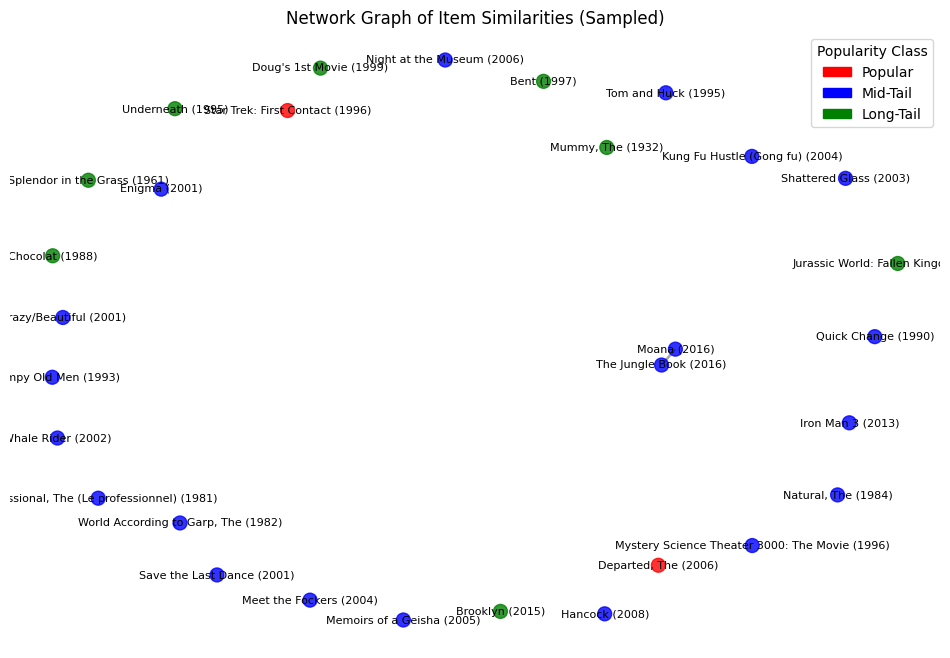

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# Parameters for visualization
sample_size = 30  # Increase the number of items to include in the sample
top_n_similar = 3  # Number of top similar items to include in the graph
threshold_similarity = 0.3  # Lower the minimum similarity score to include an edge

# Randomly sample items to limit the number of nodes
sampled_items = df_items.sample(n=sample_size, random_state=42)

# Create a new network graph for the sampled items
G = nx.Graph()

# Add nodes and edges for the sampled items based on similarity scores
for idx, row in sampled_items.iterrows():
    item_id = row['itemId']
    # Add item node to the graph, colored by popularity level
    if row['popularity_level'] == 2:
        color = 'red'
        label = 'Popular'
    elif row['popularity_level'] == 1:
        color = 'blue'
        label = 'Mid-Tail'
    else:
        color = 'green'
        label = 'Long-Tail'

    G.add_node(item_id, color=color, label=row['title'], popularity=label)

    # Connect to top N similar items with an edge if similarity is above threshold
    most_similar_ids = row['most_similar_items'][:top_n_similar]
    similarity_values = row['similarity_values'][:top_n_similar]

    for similar_id, similarity_score in zip(most_similar_ids, similarity_values):
        if similarity_score >= threshold_similarity and similar_id in sampled_items['itemId'].values:
            G.add_edge(item_id, similar_id, weight=similarity_score)

# Extract colors for the nodes
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_labels = nx.get_node_attributes(G, 'label')

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization
edges = G.edges(data=True)

# Draw nodes and edges with variable edge widths
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[edge[2]['weight'] * 2 for edge in edges], edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

# Create legend
import matplotlib.patches as mpatches
legend_labels = {'Popular': 'red', 'Mid-Tail': 'blue', 'Long-Tail': 'green'}
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=legend_patches, loc='upper right', title="Popularity Class")

plt.title("Network Graph of Item Similarities (Sampled)")
plt.axis("off")
plt.show()


## Adversaial Attack: Adversarial tag generation

In [ ]:
from collections import Counter
import ast

### LOCAL TAG SELECTION ###

def select_top_tags_local(df_items, tag_column='generated_tags', top_n=20, top_tag_n=50):
    # Initialize a new column for top tags from other popularity class
    df_items['top_tags_in_other_pop_class_local'] = None

    # Iterate through each item
    for idx, row in df_items.iterrows():
        if row['popularity_level'] in [0, 2]:
            # Get similar items in the opposite popularity class
            similar_item_ids_in_other_class = row['most_similar_items_in_otherPop_class']

            if similar_item_ids_in_other_class:
                # Select top N similar items
                top_similar_item_ids = similar_item_ids_in_other_class[:top_n]

                # Collect tags from similar items
                all_tags = []
                for item_id in top_similar_item_ids:
                    tags_list = df_items[df_items['itemId'] == item_id][tag_column].values
                    if tags_list.size > 0 and tags_list[0]:  # Check for non-empty tag lists
                        tags = tags_list[0]
                        all_tags.extend(tags)

                # Get top or least frequent tags based on item's popularity
                tag_counts = Counter(all_tags)
                # For both popular and unpopular items, select most frequent tags
                top_tags = [str(tag) for tag, _ in tag_counts.most_common(top_tag_n)]

                # Format the tags with single quotes
                formatted_tags = '[' + ', '.join(f"'{tag}'" for tag in top_tags) + ']'
                df_items.at[idx, 'top_tags_in_other_pop_class_local'] = formatted_tags
            else:
                # Assign empty list if no similar items
                df_items.at[idx, 'top_tags_in_other_pop_class_local'] = '[]'

    return df_items


### GLOBAL TAG SELECTION ###

def build_global_tag_pools(df, tag_column='generated_tags', popularity_column='popularity_level'):
    # Ensure that the tag_column contains lists
    def parse_tags(tags):
        if isinstance(tags, str):
            return ast.literal_eval(tags)
        return tags
    df[tag_column] = df[tag_column].apply(parse_tags)

    # Get tags for popular and unpopular items
    popular_tags = df[df[popularity_column] == 2][tag_column].explode().dropna()
    unpopular_tags = df[df[popularity_column] == 0][tag_column].explode().dropna()

    # Count tag frequencies for popular and unpopular tags
    popular_tag_counts = Counter(popular_tags)
    unpopular_tag_counts = Counter(unpopular_tags)

    # Convert to sorted lists of tags by frequency
    global_popular_tags = [str(tag) for tag, _ in popular_tag_counts.most_common()]
    global_unpopular_tags = [str(tag) for tag, _ in unpopular_tag_counts.most_common()]

    return {
        'popular': global_popular_tags,
        'unpopular': global_unpopular_tags
    }

def select_top_tags_global(df_items, global_tag_pools, tag_column='generated_tags', top_tag_n=20):
    # Initialize a new column for top tags from the global pools
    df_items['top_tags_in_other_pop_class_global'] = None

    # Iterate through each item
    for idx, row in df_items.iterrows():
        # Skip mid-tail items
        if row['popularity_level'] == 1:
            df_items.at[idx, 'top_tags_in_other_pop_class_global'] = '[]'
            continue

        # Check item's popularity level and select tags from the opposite global pool
        if row['popularity_level'] == 2:  # Popular item, select tags from global unpopular pool
            top_tags = global_tag_pools['unpopular'][:top_tag_n]
        elif row['popularity_level'] == 0:  # Unpopular item, select tags from global popular pool
            top_tags = global_tag_pools['popular'][:top_tag_n]

        # Format the tags with single quotes
        formatted_tags = '[' + ', '.join(f"'{tag}'" for tag in top_tags) + ']'
        df_items.at[idx, 'top_tags_in_other_pop_class_global'] = formatted_tags

    return df_items

# Ensure 'generated_tags' column contains lists
def parse_tags(tags):
    if isinstance(tags, str):
        return ast.literal_eval(tags)
    return tags

tag_column = org_colName
print("Original column name:", org_colName)
print("New column name:", tag_column)


df_items[org_colName] = df_items[org_colName].apply(parse_tags)

# Create global tag pools
global_tag_pools = build_global_tag_pools(df_items, tag_column=org_colName, popularity_column='popularity_level')

# Use the local and global tag selection functions to update the DataFrame
df_items = select_top_tags_local(df_items, tag_column=tag_column, top_n=20, top_tag_n=50)
df_items = select_top_tags_global(df_items, global_tag_pools, tag_column=tag_column, top_tag_n=20)


# Format 'generated_tags' column with single quotes around each tag
df_items[org_colName] = df_items[org_colName].apply(lambda tags: '[' + ', '.join(f"'{tag}'" for tag in tags) + ']')
display(df_items)



Original column name: tag
New column name: tag


,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags,combined_text_Tags,embedding_combined_Tagstext-embedding-ada-002,num_interactions,popularity_level,most_similar_items,similarity_values,most_similar_items_in_otherPop_class,similarity_values_in_otherPop_class,top_tags_in_other_pop_class_local,top_tags_in_other_pop_class_global
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"['hit men', 'reunion']","""Grosse Pointe Blank"" is a captivating blend o...","['forefront', 'professional', 'rollercoaster',...",forefront professional rollercoaster pointe jo...,"['debi', 'grosse', 'blank', 'pointe', 'sweethe...","Title: Grosse Pointe Blank (1997), Genre: Come...","[0.0023945507127791643, -0.03080049529671669, ...",59,2,"[41285, 1662, 1729, 4351, 1784, 1513, 2580, 40...","[0.8885439371691337, 0.8872747507801472, 0.885...","[1662, 1629, 1910, 2587, 1465, 2975, 171867, 1...","[0.8872747507801472, 0.8789369185774273, 0.873...",[],"['In Netflix queue', 'books', 'sexuality', 'ev..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,[],"""The Mask"" (1994) is a wildly entertaining act...","['genre', 'bank', 'lesson', 'embrace', 'misuse...",genre bank lesson embrace misuse slapstick tin...,"['ipkiss', 'dorian', 'misuse', 'trickster', 't...","Title: Mask, The (1994), Genre: Action|Comedy|...","[-0.011142779141664505, -0.037081919610500336,...",157,2,"[353, 533, 2006, 2617, 3213, 1801, 8880, 4161,...","[0.9248024321833965, 0.9162090011414817, 0.914...","[449, 94015, 1629, 183, 2587, 3576, 511, 12063...","[0.8969032617894339, 0.8925872275589732, 0.892...",[],"['In Netflix queue', 'books', 'sexuality', 'ev..."
2,84152,Limitless (2011),Sci-Fi|Thriller,[],"""Limitless"" (2011) is a riveting Sci-Fi thrill...","['powerful', 'smart', 'morra', 'tension', 'sky...",powerful smart morra tension skyrocket care po...,"['nootropic', 'ascent', 'morra', 'loon', 'abbi...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","[-0.0024675088934600353, -0.030259277671575546...",30,1,"[72378, 4887, 90405, 81782, 51412, 85414, 1304...","[0.910868578629457, 0.9094319407974368, 0.9080...",[],[],None,[]
3,3717,Gone in 60 Seconds (2000),Action|Crime,[],"""Gone in 60 Seconds (2000)"" is a high-octane a...","['angelina', 'auto', 'dominic', 'brother', 'st...",angelina auto dominic brother steal ensemble v...,"['vinnie', 'fifty', 'vehicle', 'auto', 'zoom',...","Title: Gone in 60 Seconds (2000), Genre: Actio...","[-0.005836763419210911, -0.014308635145425797,...",61,2,"[4369, 4011, 5507, 59369, 2273, 4265, 4889, 63...","[0.9101967499953542, 0.9081419559374172, 0.907...","[3899, 4957, 7991, 479, 27193, 692, 60753, 944...","[0.8908482038345178, 0.889850156164438, 0.8885...",[],"['In Netflix queue', 'books', 'sexuality', 'ev..."
4,3238,Eye of the Beholder (1999),Thriller,[],"""Eye of the Beholder"" (1999) is a riveting thr...","['ewan', 'tension', 'expert', 'ashley', 'obses...",ewan tension expert ashley obsession deepest s...,"['beholder', 'eris', 'joanna', 'ashley', 'judd...","Title: Eye of the Beholder (1999), Genre: Thri...","[-0.01010273490101099, -0.03785362094640732, -...",6,1,"[61, 2841, 2712, 4946, 62081, 2676, 3005, 2560...","[0.9327407338584153, 0.9094431252791868, 0.906...",[],[],None,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,['books'],"""84 Charing Cross Road"" is a heartwarming and ...","['frank', 'unlikely', 'meaningful', 'sassy', '...",frank unlikely meaningful sassy correspondence...,"['doel', 'bookseller', 'antiquarian', 'hanff',...","Title: 84 Charing Cross Road (1987), Genre: Dr...","[-0.004216748755425215, -0.01860734447836876, ...",3,0,"[1296, 4703, 3097, 1554, 1244, 1684, 5011, 339...","[0.875886047757267, 0.874862958988859, 0.86930...","[2144, 2396, 2671, 4014, 2406, 555, 2797, 1088...","[0.8647050094348717, 0.8595956104350267, 0.857...","['New York', 'high school', 'England', 'childr...","['atmospheric', 'Disney', 'tho

In [ ]:
long_tail_sample = df_items[df_items['popularity_level'] == 0].sample(50)  #
display(long_tail_sample)

,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags,combined_text_Tags,embedding_combined_Tagstext-embedding-ada-002,num_interactions,popularity_level,most_similar_items,similarity_values,most_similar_items_in_otherPop_class,similarity_values_in_otherPop_class,top_tags_in_other_pop_class_local,top_tags_in_other_pop_class_global
670,40870,C.R.A.Z.Y. (2005),Drama,[],"""C.R.A.Z.Y."" (2005) is a Canadian coming-of-ag...","['sibling', 'self', 'unconditional', 'feeling'...",sibling self unconditional feeling balance sex...,"['beaulieu', 'grondin', 'vallée', 'montreal', ...","Title: C.R.A.Z.Y. (2005), Genre: Drama, Tags: []","[-0.016242628917098045, -0.0179985873401165, -...",2,0,"[4372, 74685, 44974, 46231, 39869, 2977, 2482,...","[0.9171528440444991, 0.9075811279129952, 0.903...","[33166, 4022, 2539, 2541, 3785, 441, 8798, 802...","[0.8838038753277562, 0.8782547829387457, 0.876...","['racism', 'stiller']","['atmospheric', 'Disney', 'thought-provoking',..."
520,4802,Operation Petticoat (1959),Action|Comedy|Romance|War,[],"""Operation Petticoat"" is a delightful blend of...","['hollywood', 'contrast', 'ii', 'comical', 'te...",hollywood contrast ii comical tension matt cir...,"['petticoat', 'jg', 'crandall', 'merrill', 'di...","Title: Operation Petticoat (1959), Genre: Acti...","[-0.035870980471372604, -0.03502196446061134, ...",4,0,"[688, 127052, 3035, 6658, 3022, 5541, 3766, 43...","[0.8840971076356191, 0.8783834187473046, 0.878...","[2406, 1101, 151, 597, 3753, 2321, 2724, 4310,...","[0.8656582653851791, 0.8655841397078033, 0.864...","['predictable', 'Navy', 'prostitution', 'Civil...","['atmospheric', 'Disney', 'thought-provoking',..."
265,26524,"Times of Harvey Milk, The (1984)",Documentary,[],"""The Times of Harvey Milk"" is a riveting and e...","['tireless', 'powerful', 'effort', 'political'...",tireless powerful effort political representat...,"['advocacy', 'testimonial', 'epstein', 'trailb...","Title: Times of Harvey Milk, The (1984), Genre...","[-0.013182894326746464, -0.030336540192365646,...",2,0,"[63876, 276, 137, 4703, 26366, 117533, 6055, 3...","[0.891731553374757, 0.8784984645155526, 0.8625...","[225, 2144, 4014, 1968, 8464, 4085, 2539, 1674...","[0.8547350899592455, 0.841720320411609, 0.8404...","['food', 'McDonalds', 'Amish', 'AIDs', 'Mozart...","['atmospheric', 'Disney', 'thought-provoking',..."
2107,44633,"Devil and Daniel Johnston, The (2005)",Documentary,[],"""The Devil and Daniel Johnston"" is a mesmerizi...","['profound', 'texas', 'recording', 'music', 'l...",profound texas recording music life raw early ...,"['feuerzeig', 'bipolar', 'recording', 'schizop...","Title: Devil and Daniel Johnston, The (2005), ...","[-0.02168867364525795, -0.0016289848135784268,...",1,0,"[38304, 1488, 46231, 27846, 190213, 5325, 5562...","[0.8790923975427523, 0.8741837926256268, 0.870...","[1645, 225, 91658, 3863, 4720, 55247, 47099, 3...","[0.8537739159006341, 0.8443542828732513, 0.842...","['music', 'lawyers', 'journalism', 'Rolling St...","['atmospheric', 'Disney', 'thought-provoking',..."
610,879,"Relic, The (1997)",Horror|Thriller,[],"""Relic"" (1997) is a chilling horror-thriller f...","['confines', 'beneath', 'dig', 'nightmare', 't...",confines beneath dig nightmare tension inhabit...,"['evolutionary', 'awoken', 'margo', 'hyams', '...","Title: Relic, The (1997), Genre: Horror|Thrill...","[-0.001525162486359477, -0.030909961089491844,...",4,0,"[311, 57274, 1690, 1603, 2719, 1998, 188, 2560...","[0.9129580931076517, 0.909332236276805, 0.9091...","[1690, 196, 4720, 5679, 2617, 3863, 225, 3785,...","[0.909176614796775, 0.9014331746957076, 0.8985...","['aliens', 'demons']","['atmospheric', 'Disney', 'thought-provoking',..."
2304,3447,"Good Earth, The (1937)",Drama,['Pearl S Buck'],"""The Good Earth"" released in 1937 is a powerfu...","['powerful', 'novel', 'fortune', 'prosperous',...",powerful novel fortune prosperous change tapes...,"['luise', 'prosperous', 'muni', 'rainer', 'lun...","Title: 

## Tag selection for adversarial attack tag selection

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import ast
import re

def parse_tags(tags):
    if isinstance(tags, str):
        try:
            return ast.literal_eval(tags)
        except Exception as e:
            print(f"Error parsing tags with ast.literal_eval: {tags}")
            print(f"Exception: {e}")
            # Remove square brackets
            tags_clean = tags.strip('[]')
            # Use regex to find all substrings enclosed in single or double quotes
            tag_list = re.findall(r"'(.*?)'|\"(.*?)\"", tags_clean)
            # Flatten the list of tuples
            tag_list = [t[0] or t[1] for t in tag_list]
            return tag_list
    elif isinstance(tags, list):
        return tags
    else:
        return []

def compute_tag_frequencies(df, tag_column='generated_tags', popularity_column='popularity_level'):
    # Ensure that the tag_column contains lists
    df[tag_column] = df[tag_column].apply(parse_tags)

    # Explode tags for each popularity class
    tags_popular = df[df[popularity_column] == 2][tag_column].explode().dropna()
    tags_unpopular = df[df[popularity_column] == 0][tag_column].explode().dropna()

    # Count tag frequencies
    freq_popular = Counter(tags_popular)
    freq_unpopular = Counter(tags_unpopular)

    # Total number of tags in each class
    total_tags_popular = sum(freq_popular.values())
    total_tags_unpopular = sum(freq_unpopular.values())

    return freq_popular, freq_unpopular, total_tags_popular, total_tags_unpopular

def compute_adversarial_scores(freq_popular, freq_unpopular, total_tags_popular, total_tags_unpopular, epsilon=1e-6):
    all_tags = set(freq_popular.keys()).union(set(freq_unpopular.keys()))
    adversarial_scores = {}

    for tag in all_tags:
        # Probabilities with Laplace smoothing
        P_t_popular = (freq_popular.get(tag, 0) + epsilon) / (total_tags_popular + epsilon * len(all_tags))
        P_t_unpopular = (freq_unpopular.get(tag, 0) + epsilon) / (total_tags_unpopular + epsilon * len(all_tags))

        # Adversarial score
        adversarial_scores[tag] = np.log(P_t_unpopular / P_t_popular)  # Adjusted to focus on unpopular vs. popular

    return adversarial_scores

def select_adversarial_tags(df_items, adversarial_scores, tag_pool_column, tag_column_prefix, k_values):
    # Initialize new columns for each k in k_values
    for k in k_values:
        df_items[f'{tag_column_prefix}_{k}'] = None

    for idx, row in df_items.iterrows():
        popularity = row['popularity_level']
        candidate_tags_str = row[tag_pool_column]
        if pd.isna(candidate_tags_str):
            candidate_tags = []
        else:
            candidate_tags = parse_tags(candidate_tags_str)

        # For each tag, get the adversarial score
        tag_scores = []
        for tag in candidate_tags:
            score = adversarial_scores.get(tag.strip("'"), 0)
            tag_scores.append((tag.strip("'"), score))

        # Sort tags by adversarial score
        if popularity == 0:
            # Unpopular item: select tags with positive scores (more popular)
            tag_scores.sort(key=lambda x: x[1], reverse=True)
        elif popularity == 2:
            # Popular item: select tags with negative scores (more unpopular)
            tag_scores.sort(key=lambda x: x[1])
        else:
            continue  # Skip mid-tail items

        # Assign top k tags for each specified k
        for k in k_values:
            top_k_tags = [f"'{tag}'" for tag, _ in tag_scores[:k]]
            formatted_tags = '[' + ', '.join(top_k_tags) + ']'
            df_items.at[idx, f'{tag_column_prefix}_{k}'] = formatted_tags

    return df_items

# Compute tag frequencies
freq_popular, freq_unpopular, total_tags_popular, total_tags_unpopular = compute_tag_frequencies(df_items, tag_column=tag_column)

# Compute adversarial scores for tags
adversarial_scores = compute_adversarial_scores(freq_popular, freq_unpopular, total_tags_popular, total_tags_unpopular)

# Select tags for local and global pools
k_values = [1, 3, 5, 7]
df_items = select_adversarial_tags(df_items, adversarial_scores, 'top_tags_in_other_pop_class_local', 'adversarial_tags_local', k_values)
df_items = select_adversarial_tags(df_items, adversarial_scores, 'top_tags_in_other_pop_class_global', 'adversarial_tags_global', k_values)

# Display the updated DataFrame
df_items[org_colName] = df_items[org_colName].apply(lambda tags: '[' + ', '.join(f"'{tag}'" for tag in tags) + ']')
display(df_items)


Error parsing tags with ast.literal_eval: ['good dialogue', 'great soundtrack', 'non-linear', 'cult film', 'drugs', 'Quentin Tarantino', 'Tarantino', 'hit men', '1990s', 'achronological', 'action', 'action packed', 'aggressive', 'amazing', 'amazing dialogues', 'anthology', 'assassin', 'atmospheric', 'AWESOME', 'bad ass', 'bad language', 'bad-ass', 'bible', 'biblical references', 'big boys with guns', 'big name actors', 'Black comedy', 'black humor', 'black humour', 'blood', 'blood splatters', 'bloody', 'bruce willis', 'brutality', 'casual violence', 'character development', 'characters', 'classic', 'classic movie', 'coke', 'comedy', 'conversation', 'cool', 'cool style', 'crime', 'crime scene scrubbing', 'cult', 'cult classic', 'cult film', 'dance', 'dancing', 'dark', 'dark comedy', 'dark humor', 'dialogue', 'different', 'diner', 'disjointed timeline', 'disturbing', 'drama', 'drug overdose', 'drugs', 'drugs & music', 'ensemble cast', 'entertaining', 'entirely dialogue', 'episodic', 'exc

,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags,combined_text_Tags,embedding_combined_Tagstext-embedding-ada-002,...,top_tags_in_other_pop_class_local,top_tags_in_other_pop_class_global,adversarial_tags_local_1,adversarial_tags_local_3,adversarial_tags_local_5,adversarial_tags_local_7,adversarial_tags_global_1,adversarial_tags_global_3,adversarial_tags_global_5,adversarial_tags_global_7
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"['hit men', 'reunion']","""Grosse Pointe Blank"" is a captivating blend o...","['forefront', 'professional', 'rollercoaster',...",forefront professional rollercoaster pointe jo...,"['debi', 'grosse', 'blank', 'pointe', 'sweethe...","Title: Grosse Pointe Blank (1997), Genre: Come...","[0.0023945507127791643, -0.03080049529671669, ...",...,[],"['In Netflix queue', 'books', 'sexuality', 'ev...",[],[],[],[],['satire'],"['satire', 'future', 'religion']","['satire', 'future', 'religion', 'court', 'sex...","['satire', 'future', 'religion', 'court', 'sex..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,[],"""The Mask"" (1994) is a wildly entertaining act...","['genre', 'bank', 'lesson', 'embrace', 'misuse...",genre bank lesson embrace misuse slapstick tin...,"['ipkiss', 'dorian', 'misuse', 'trickster', 't...","Title: Mask, The (1994), Genre: Action|Comedy|...","[-0.011142779141664505, -0.037081919610500336,...",...,[],"['In Netflix queue', 'books', 'sexuality', 'ev...",[],[],[],[],['satire'],"['satire', 'future', 'religion']","['satire', 'future', 'religion', 'court', 'sex...","['satire', 'future', 'religion', 'court', 'sex..."
2,84152,Limitless (2011),Sci-Fi|Thriller,[],"""Limitless"" (2011) is a riveting Sci-Fi thrill...","['powerful', 'smart', 'morra', 'tension', 'sky...",powerful smart morra tension skyrocket care po...,"['nootropic', 'ascent', 'morra', 'loon', 'abbi...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","[-0.0024675088934600353, -0.030259277671575546...",...,None,[],None,None,None,None,None,None,None,None
3,3717,Gone in 60 Seconds (2000),Action|Crime,[],"""Gone in 60 Seconds (2000)"" is a high-octane a...","['angelina', 'auto', 'dominic', 'brother', 'st...",angelina auto dominic brother steal ensemble v...,"['vinnie', 'fifty', 'vehicle', 'auto', 'zoom',...","Title: Gone in 60 Seconds (2000), Genre: Actio...","[-0.005836763419210911, -0.014308635145425797,...",...,[],"['In Netflix queue', 'books', 'sexuality', 'ev...",[],[],[],[],['satire'],"['satire', 'future', 'religion']","['satire', 'future', 'religion', 'court', 'sex...","['satire', 'future', 'religion', 'court', 'sex..."
4,3238,Eye of the Beholder (1999),Thriller,[],"""Eye of the Beholder"" (1999) is a riveting thr...","['ewan', 'tension', 'expert', 'ashley', 'obses...",ewan tension expert ashley obsession deepest s...,"['beholder', 'eris', 'joanna', 'ashley', 'judd...","Title: Eye of the Beholder (1999), Genre: Thri...","[-0.01010273490101099, -0.03785362094640732, -...",...,None,[],None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,['books'],"""84 Charing Cross Road"" is a heartwarming and ...","['frank', 'unlikely', 'meaningful', 'sassy', '...",frank unlikely meaningful sassy correspondence...,"['doel', 'bookseller', 'antiquarian', 'hanff',...","Title: 84 Charing Cross Road (1987), Genre: Dr...","[-0.004216748755425215, -0.01860734447836876, ...",...,"['New York', 'high school', 'England', 'childr...","['atmospheric', 'Disney', 'thought-provoking',...",['New York'],"['New York', 'start of a beautiful friendship'...","['New York', 'start of a beautiful friendship'...","['New York', 'start of a beautiful friendship'...",['psychological'],"['psychological', 'suspense', 'aliens']","['psychological', 'suspense', 'aliens', 'class...","['psychological', 'suspense', 'aliens', 'class..."
3075,53894,Sicko (2007),Documentary|Drama,[],"""Sicko"" (2007

In [ ]:
import openai
import pandas as pd
import time
from tqdm import tqdm
from openai.error import RateLimitError

openai.api_key = api_key  # Replace with your actual API key

model = 'text-embedding-ada-002'  # 'text-embedding-3-large' or 'text-embedding-ada-002'

def get_embedding(text, model=model, temperature=1):
    max_retries = 5
    for retry in range(max_retries):
        try:
            response = openai.Embedding.create(
                input=text,
                model=model,
                temperature=temperature
            )
            embedding = response['data'][0]['embedding']
            return embedding
        except RateLimitError:
            print(f"Rate limit reached. Retrying in {2 ** retry} seconds...")
            time.sleep(2 ** retry)
    print("Failed to retrieve embedding after multiple retries.")
    return None

def clean_tags(tags):
    """Remove brackets and quotes from the list of tags if they exist."""
    if tags is None:
        return ""  # Return an empty string if tags is None
    elif isinstance(tags, str):
        # Remove brackets and split tags by comma if it's a string representation of a list
        tags = tags.strip("[]").replace("'", "").replace('"', "").split(", ")
    elif isinstance(tags, list):
        # If tags are already a list, convert each element to string and strip quotes
        tags = [tag.strip("'\"") for tag in tags]
    else:
        return ""  # Return empty string if tags is an unexpected type
    return ", ".join(tags)  # Join tags with commas


# Measure the time before starting
start_time = time.time()

# Define values of k to use in combination with tags
k_values = [5, 7] #, 5, 7]

# Prepare to store embeddings for each combination of 'tag' and local/global tags for each k
for k in k_values:
    # Create new combined text fields for each k in local and global tag sets, cleaning the tags
    df_items[f'combined_text_tag_local_k{k}'] = df_items.apply(
        lambda row: f"Title: {row['title']}, Genre: {row['genres']}, Tags: {clean_tags(row[tag_column])}, {clean_tags(row[f'adversarial_tags_local_{k}'])}", axis=1
    )
    df_items[f'combined_text_tag_global_k{k}'] = df_items.apply(
        lambda row: f"Title: {row['title']}, Genre: {row['genres']}, Tags: {clean_tags(row[tag_column])}, {clean_tags(row[f'adversarial_tags_global_{k}'])}", axis=1
    )

# Extract embeddings for each of the combined text fields
for k in k_values:
    embeddings_local = []
    embeddings_global = []

    # Process embeddings for 'tag' + local tags for each k
    for text in tqdm(df_items[f'combined_text_tag_local_k{k}'], desc=f"Processing embeddings for {tag_column} + local k={k}"):
        embeddings_local.append(get_embedding(text, model))
        time.sleep(0.3)  # Pause between API calls

    # Process embeddings for 'tag' + global tags for each k
    for text in tqdm(df_items[f'combined_text_tag_global_k{k}'], desc=f"Processing embeddings for {tag_column} + global k={k}"):
        embeddings_global.append(get_embedding(text, model))
        time.sleep(0.3)  # Pause between API calls

    # Add the embeddings to the dataframe
    df_items[f'embedding_tag_local_k{k}_{model}'] = embeddings_local
    df_items[f'embedding_tag_global_k{k}_{model}'] = embeddings_global

# Measure the time after processing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to process embeddings: {elapsed_time} seconds")


# Display the first few rows to verify embeddings are added correctly
display(df_items.head())


Processing embeddings for tag + global k=7: 100%|██████████| 3079/3079 [29:42<00:00,  1.73it/s]

Time taken to process embeddings: 6907.950297117233 seconds


,itemId,title,genres,tag,enriched_description,filtered_tokens,filtered_text,generated_tags,combined_text_Tags,embedding_combined_Tagstext-embedding-ada-002,...,adversarial_tags_global_5,adversarial_tags_global_7,combined_text_tag_local_k5,combined_text_tag_global_k5,combined_text_tag_local_k7,combined_text_tag_global_k7,embedding_tag_local_k5_text-embedding-ada-002,embedding_tag_global_k5_text-embedding-ada-002,embedding_tag_local_k7_text-embedding-ada-002,embedding_tag_global_k7_text-embedding-ada-002
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"['hit men', 'reunion']","""Grosse Pointe Blank"" is a captivating blend o...","['forefront', 'professional', 'rollercoaster',...",forefront professional rollercoaster pointe jo...,"['debi', 'grosse', 'blank', 'pointe', 'sweethe...","Title: Grosse Pointe Blank (1997), Genre: Come...","[0.0023945507127791643, -0.03080049529671669, ...",...,"['satire', 'future', 'religion', 'court', 'sex...","['satire', 'future', 'religion', 'court', 'sex...","Title: Grosse Pointe Blank (1997), Genre: Come...","Title: Grosse Pointe Blank (1997), Genre: Come...","Title: Grosse Pointe Blank (1997), Genre: Come...","Title: Grosse Pointe Blank (1997), Genre: Come...","[0.0052009886130690575, -0.03144115209579468, ...","[0.013045919127762318, -0.03413036838173866, -...","[0.0052009886130690575, -0.03144115209579468, ...","[0.01194033119827509, -0.03353681415319443, -0..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,[],"""The Mask"" (1994) is a wildly entertaining act...","['genre', 'bank', 'lesson', 'embrace', 'misuse...",genre bank lesson embrace misuse slapstick tin...,"['ipkiss', 'dorian', 'misuse', 'trickster', 't...","Title: Mask, The (1994), Genre: Action|Comedy|...","[-0.011142779141664505, -0.037081919610500336,...",...,"['satire', 'future', 'religion', 'court', 'sex...","['satire', 'future', 'religion', 'court', 'sex...","Title: Mask, The (1994), Genre: Action|Comedy|...","Title: Mask, The (1994), Genre: Action|Comedy|...","Title: Mask, The (1994), Genre: Action|Comedy|...","Title: Mask, The (1994), Genre: Action|Comedy|...","[-0.008226941339671612, -0.03270556777715683, ...","[-0.007382850628346205, -0.029636871069669724,...","[-0.008226941339671612, -0.03270556777715683, ...","[-0.005454235710203648, -0.03195278346538544, ..."
2,84152,Limitless (2011),Sci-Fi|Thriller,[],"""Limitless"" (2011) is a riveting Sci-Fi thrill...","['powerful', 'smart', 'morra', 'tension', 'sky...",powerful smart morra tension skyrocket care po...,"['nootropic', 'ascent', 'morra', 'loon', 'abbi...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","[-0.0024675088934600353, -0.030259277671575546...",...,None,None,"Title: Limitless (2011), Genre: Sci-Fi|Thrille...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","Title: Limitless (2011), Genre: Sci-Fi|Thrille...","[-0.0020240123849362135, -0.03039936162531376,...","[-0.0020240123849362135, -0.03039936162531376,...","[-0.0020240123849362135, -0.03039936162531376,...","[-0.0020240123849362135, -0.03039936162531376,..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,[],"""Gone in 60 Seconds (2000)"" is a high-octane a...","['angelina', 'auto', 'dominic', 'brother', 'st...",angelina auto dominic brother steal ensemble v...,"['vinnie', 'fifty', 'vehicle', 'auto', 'zoom',...","Title: Gone in 60 Seconds (2000), Genre: Actio...","[-0.005836763419210911, -0.014308635145425797,...",...,"['satire', 'future', 'religion', 'court', 'sex...","['satire', 'future', 'religion', 'court', 'sex...","Title: Gone in 60 Seconds (2000), Genre: Actio...","Title: Gone in 60 Seconds (2000), Genre: Actio...","Title: Gone in 60 Seconds (2000), Genre: Actio...","Title: Gone in 60 Seconds (2000), Genre: Actio...","[-0.0033510427456349134, -0.011148784309625626...","[0.0030198136810213327, -0.00950128398835659, ...","[-0.0033510427456349134, -0.011148784309625626...","[0.0011014669435098767, -0.010428748093545437,..."
4,3238,Eye of

In [ ]:
import pandas as pd

# Define the columns for each DataFrame
columns_df1 = ['itemId', 'title', 'genres', 'embedding_tag_local_k5_text-embedding-ada-002', 'embedding_tag_global_k5_text-embedding-ada-002']
columns_df2 = ['itemId', 'title', 'genres', 'embedding_tag_local_k7_text-embedding-ada-002', 'embedding_tag_global_k7_text-embedding-ada-002']

# Create DataFrame1 with the specified columns
df1 = df_items[columns_df1]

# Create DataFrame2 with the specified columns
df2 = df_items[columns_df2]

display(df1)
display(df2)
# Save each DataFrame as a separate CSV file
output_file = f"df_items_adversarialAttack_with_embeddings_{tag_column}_5.csv"
df1.to_csv(output_file, index=False)

output_file = f"df_items_adversarialAttack_with_embeddings_{tag_column}_7.csv"
df2.to_csv(output_file, index=False)

print("DataFrames have been split and saved as 'dataframe1.csv' and 'dataframe2.csv'.")


,itemId,title,genres,embedding_tag_local_k5_text-embedding-ada-002,embedding_tag_global_k5_text-embedding-ada-002
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"[0.0052009886130690575, -0.03144115209579468, ...","[0.013045919127762318, -0.03413036838173866, -..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"[-0.008226941339671612, -0.03270556777715683, ...","[-0.007382850628346205, -0.029636871069669724,..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"[-0.0020240123849362135, -0.03039936162531376,...","[-0.0020240123849362135, -0.03039936162531376,..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"[-0.0033510427456349134, -0.011148784309625626...","[0.0030198136810213327, -0.00950128398835659, ..."
4,3238,Eye of the Beholder (1999),Thriller,"[-0.00863891001790762, -0.035103727132081985, ...","[-0.00863891001790762, -0.035103727132081985, ..."
...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,"[0.008860516361892223, -0.013957729563117027, ...","[0.016122132539749146, -0.018943505361676216, ..."
3075,53894,Sicko (2007),Documentary|Drama,"[-0.0052590579725801945, 0.002840989036485553,...","[-0.0052590579725801945, 0.002840989036485553,..."
3076,1342,Candyman (1992),Horror|Thriller,"[0.0022951478604227304, -0.034522056579589844,...","[0.0022951478604227304, -0.034522056579589844,..."
3077,2917,Body Heat (1981),Crime|Thriller,"[-0.010218781419098377, -0.014685054309666157,...","[-0.010218781419098377, -0.014685054309666157,..."


,itemId,title,genres,embedding_tag_local_k7_text-embedding-ada-002,embedding_tag_global_k7_text-embedding-ada-002
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"[0.0052009886130690575, -0.03144115209579468, ...","[0.01194033119827509, -0.03353681415319443, -0..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"[-0.008226941339671612, -0.03270556777715683, ...","[-0.005454235710203648, -0.03195278346538544, ..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"[-0.0020240123849362135, -0.03039936162531376,...","[-0.0020240123849362135, -0.03039936162531376,..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"[-0.0033510427456349134, -0.011148784309625626...","[0.0011014669435098767, -0.010428748093545437,..."
4,3238,Eye of the Beholder (1999),Thriller,"[-0.00863891001790762, -0.035103727132081985, ...","[-0.00863891001790762, -0.035103727132081985, ..."
...,...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,"[0.0038175778463482857, -0.015427198261022568,...","[0.015706894919276237, -0.021564366295933723, ..."
3075,53894,Sicko (2007),Documentary|Drama,"[-0.0052590579725801945, 0.002840989036485553,...","[-0.0052590579725801945, 0.002840989036485553,..."
3076,1342,Candyman (1992),Horror|Thriller,"[0.0022951478604227304, -0.034522056579589844,...","[0.0022951478604227304, -0.034522056579589844,..."
3077,2917,Body Heat (1981),Crime|Thriller,"[-0.010218781419098377, -0.014685054309666157,...","[-0.010218781419098377, -0.014685054309666157,..."


DataFrames have been split and saved as 'dataframe1.csv' and 'dataframe2.csv'.


In [ ]:
display(df1.tail(50))
display(df2.tail(50))

,itemId,title,genres,embedding_tag_local_k5_text-embedding-ada-002,embedding_tag_global_k5_text-embedding-ada-002
3029,5746,Galaxy of Terror (Quest) (1981),Action|Horror|Mystery|Sci-Fi,"[-0.0074628801085054874, -0.04962815344333649,...","[-0.008929437026381493, -0.03983902931213379, ..."
3030,63113,Quantum of Solace (2008),Action|Adventure|Thriller,"[-0.01412504818290472, -0.00915656890720129, -...","[-0.01412504818290472, -0.00915656890720129, -..."
3031,1633,Ulee's Gold (1997),Drama,"[0.009595929645001888, -0.03433920815587044, -...","[0.009595929645001888, -0.03433920815587044, -..."
3032,5065,"Mothman Prophecies, The (2002)",Drama|Fantasy|Horror|Mystery|Thriller,"[1.0289687452313956e-05, -0.03580949082970619,...","[1.0289687452313956e-05, -0.03580949082970619,..."
3033,2538,Dancemaker (1998),Documentary,"[-0.018260415643453598, -0.038452595472335815,...","[-0.0037855131085962057, -0.029343605041503906..."
3034,3957,Billy Jack (1971),Action|Drama,"[-0.021651266142725945, -0.04291977360844612, ...","[-0.0057463631965219975, -0.034912966191768646..."
3035,91976,"Grey, The (2012)",Action|Drama,"[-0.006677526980638504, -0.025279918685555458,...","[-0.006677526980638504, -0.025279918685555458,..."
3036,8950,The Machinist (2004),Drama|Mystery|Thriller,"[-0.015585863962769508, -0.005852796137332916,...","[-0.015585863962769508, -0.005852796137332916,..."
3037,55768,Bee Movie (2007),Animation|Comedy,"[-0.015016759745776653, -0.03355951979756355, ...","[-0.015016759745776653, -0.03355951979756355, ..."
3038,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,"[-0.009148729033768177, -0.030924217775464058,...","[-0.00043816881952807307, -0.03421951830387115..."


,itemId,title,genres,embedding_tag_local_k7_text-embedding-ada-002,embedding_tag_global_k7_text-embedding-ada-002
3029,5746,Galaxy of Terror (Quest) (1981),Action|Horror|Mystery|Sci-Fi,"[-0.010144872590899467, -0.0474226176738739, -...","[-0.00873333029448986, -0.0438745878636837, -0..."
3030,63113,Quantum of Solace (2008),Action|Adventure|Thriller,"[-0.01412504818290472, -0.00915656890720129, -...","[-0.01412504818290472, -0.00915656890720129, -..."
3031,1633,Ulee's Gold (1997),Drama,"[0.009595929645001888, -0.03433920815587044, -...","[0.009595929645001888, -0.03433920815587044, -..."
3032,5065,"Mothman Prophecies, The (2002)",Drama|Fantasy|Horror|Mystery|Thriller,"[1.0289687452313956e-05, -0.03580949082970619,...","[1.0289687452313956e-05, -0.03580949082970619,..."
3033,2538,Dancemaker (1998),Documentary,"[-0.018260415643453598, -0.038452595472335815,...","[-0.0016481077764183283, -0.03077811934053898,..."
3034,3957,Billy Jack (1971),Action|Drama,"[-0.021651266142725945, -0.04291977360844612, ...","[-0.0017475784989073873, -0.03905699402093887,..."
3035,91976,"Grey, The (2012)",Action|Drama,"[-0.006677526980638504, -0.025279918685555458,...","[-0.006677526980638504, -0.025279918685555458,..."
3036,8950,The Machinist (2004),Drama|Mystery|Thriller,"[-0.015585863962769508, -0.005852796137332916,...","[-0.015585863962769508, -0.005852796137332916,..."
3037,55768,Bee Movie (2007),Animation|Comedy,"[-0.015016759745776653, -0.03355951979756355, ...","[-0.015016759745776653, -0.03355951979756355, ..."
3038,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,"[-0.009148729033768177, -0.030924217775464058,...","[0.0009582081111148, -0.03279772773385048, -0...."
